## Bibliotecas

In [12]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from scipy.spatial import distance_matrix
from adjustText import adjust_text

## Datos

In [2]:
# Ruta al archivo
file_path = "../data/Towns_HB_2024-08-14.xlsx"

# Leer todas las hojas como un diccionario {nombre_hoja: DataFrame}
all_sheets = pd.read_excel(file_path, sheet_name=None)

# Filtrar solo las hojas que tienen datos (al menos una fila no vacía)
non_empty_sheets = {name: df for name, df in all_sheets.items() if not df.dropna(how='all').empty}

# Mostrar nombres de hojas con datos
print(f"Hojas con datos: {list(non_empty_sheets.keys())}")

Hojas con datos: ['Towns', 'Triple Alliance towns', 'Tenochtitlan', 'Zempoala', '79 Destinations', 'Tecpilpan']


In [3]:
df_towns = non_empty_sheets["Towns"]
df_triple_alliance = non_empty_sheets["Triple Alliance towns"]
df_tenochtitlan = non_empty_sheets["Tenochtitlan"]
df_zempoala = non_empty_sheets["Zempoala"]
df_79 = non_empty_sheets["79 Destinations"]
df_tecpilpan = non_empty_sheets["Tecpilpan"]

### Definir coordenadas y pueblos

In [4]:
df_towns.columns

Index(['Clave', 'Toponym', 'PopSV', 'PopJV', 'Population', 'PopulationRank',
       'Pop-Ref', 'Revisado', 'Homonym', 'idGibson', 'idGA', 'idHB', 'idSV',
       'idHicks', 'ModernName', 'OtherNames', 'Municipality', 'State',
       'Latitude', 'Longitude', 'CoordSource', 'Ethnicity', 'Politics',
       'Realm', 'Estatus', 'SubjectTo', 'PoliticalCode', 'PoliticalRank',
       'Territory', 'nSubjectTowns', 'TerritorialRank', 'Military', 'Tribute',
       'Tributaries', 'Economy', 'Market', 'EarlyMartekStatus',
       'LateMarketStatus', 'Dock', 'CeremonialCenter', 'Other', 'Bibliography',
       'Observations', 'SourcePlacename', 'NameTranslation', 'TranslatedBy',
       'SourceGlyph', 'ChangeName'],
      dtype='object')

In [5]:
coords = df_towns[["Longitude", "Latitude"]].values
names = df_towns["Toponym"].values

## Graficar

In [28]:
def plot_points(coords, names):
    plt.figure(figsize=(15, 15))
    plt.scatter(coords[:, 0], coords[:, 1], color='blue', s=50)

    texts = []
    for i, (x, y) in enumerate(coords):
        texts.append(plt.text(x, y, names[i], fontsize=8))

    plt.xlabel("Longitud")
    plt.ylabel("Latitud")
    plt.title("Pueblos: solo puntos")
    plt.axis("equal")
    plt.grid(True)

    # Adjust labels with arrows for only those that overlap
    adjust_text(
        texts,
        arrowprops=dict(
            arrowstyle='->',
            color='gray',
            lw=0.5,
            shrinkA=5  # Avoid arrow piercing text
        ),
        expand_points=(1.2, 1.2),
        force_text=0.5,
        force_points=0.2
    )

    plt.show()

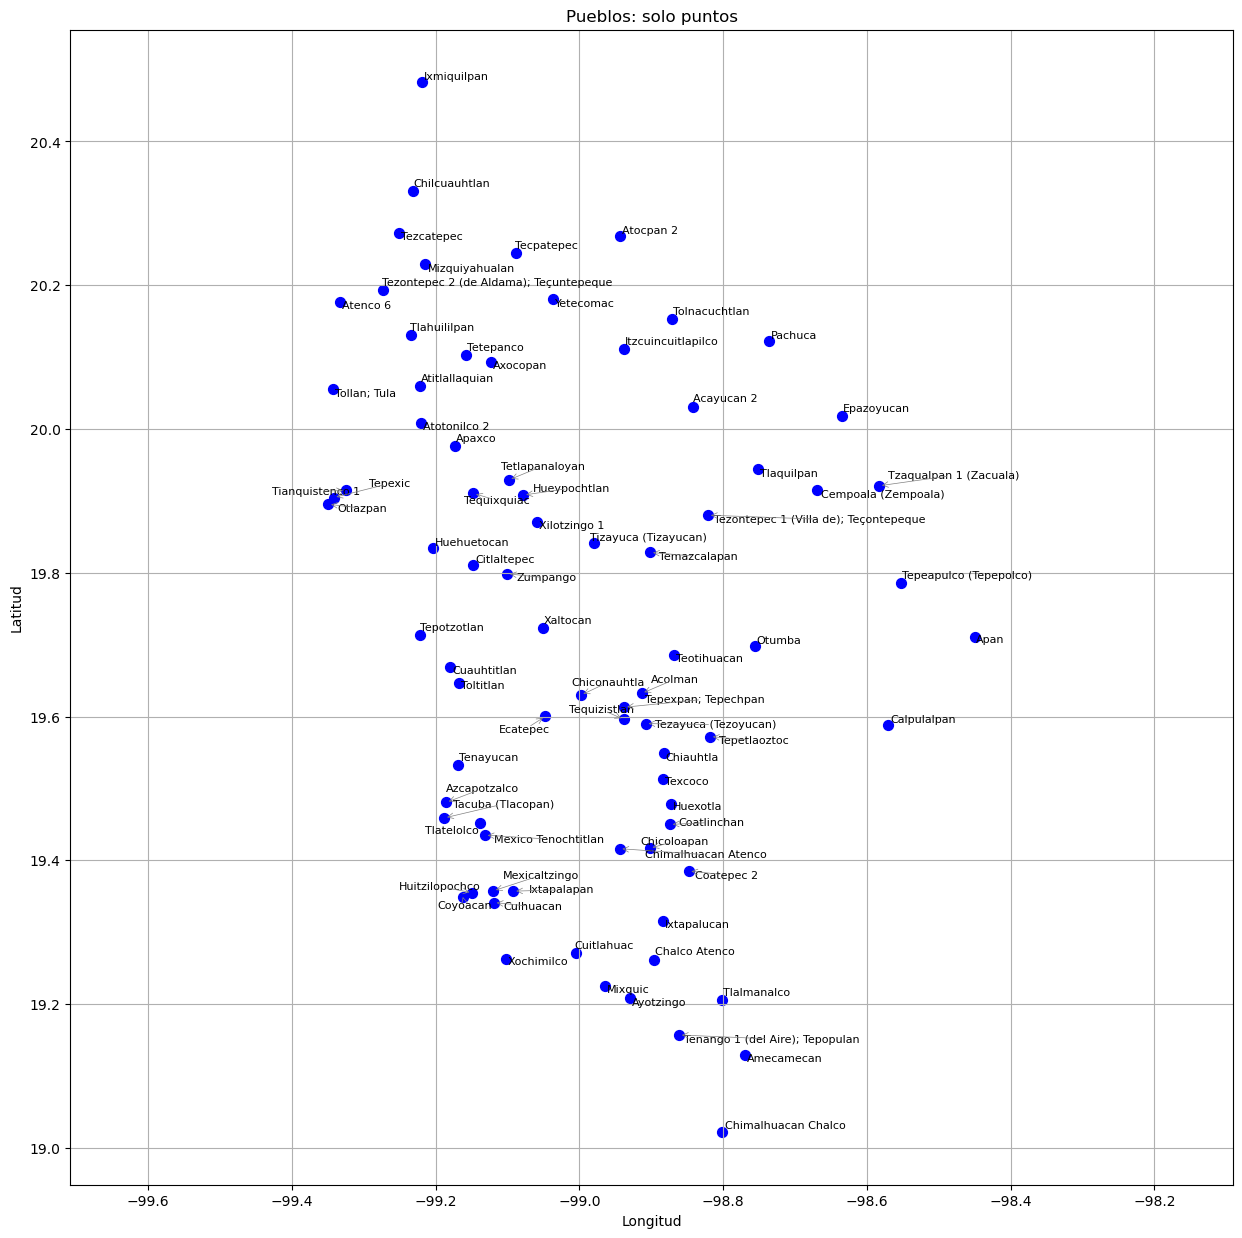

In [29]:
plot_points(coords, names)

### Revisar una distancia de un nodo

In [10]:
def plot_beta_tangent_circles(coords, names, i=7, j=13, beta=1.0):
    p1 = coords[i]
    p2 = coords[j]
    d = np.linalg.norm(p2 - p1)

    if beta < 1:
        raise ValueError("Beta debe ser ≥ 1 para una construcción válida.")

    r = (beta * d) / 2
    direction = (p2 - p1) / d

    center1 = p1 + direction * r
    center2 = p2 - direction * r

    fig, ax = plt.subplots(figsize=(10, 10))

    # Determinar qué puntos están dentro de los círculos
    in_lune = []
    out_lune = []
    for k, pk in enumerate(coords):
        if k in (i, j):
            continue  # No analizar los dos puntos principales
        dist1 = np.linalg.norm(pk - center1)
        dist2 = np.linalg.norm(pk - center2)
        if dist1 < r or dist2 < r:
            in_lune.append((pk, names[k]))
        else:
            out_lune.append((pk, names[k]))

    # Graficar puntos fuera de la luna
    if out_lune:
        x_out, y_out = zip(*[p for p, _ in out_lune])
        ax.scatter(x_out, y_out, color='lightgray', label='Otros pueblos fuera de la luna')
    
    # Graficar puntos dentro de la luna
    if in_lune:
        x_in, y_in = zip(*[p for p, _ in in_lune])
        ax.scatter(x_in, y_in, color='blue', label='Pueblos dentro de la luna')

    # Graficar los puntos evaluados
    ax.scatter([p1[0], p2[0]], [p1[1], p2[1]], color='red', label='Puntos evaluados', zorder=3)

    # Etiquetas
    ax.text(p1[0] + 0.0003, p1[1] + 0.0003, names[i], fontsize=9)
    ax.text(p2[0] + 0.0003, p2[1] + 0.0003, names[j], fontsize=9)

    # Círculos
    ax.add_patch(Circle(center1, r, color='blue', fill=False, linestyle='--', label=f"Círculo tangente a {names[i]}"))
    ax.add_patch(Circle(center2, r, color='green', fill=False, linestyle='--', label=f"Círculo tangente a {names[j]}"))

    # Línea entre puntos evaluados
    ax.plot([p1[0], p2[0]], [p1[1], p2[1]], 'k--', alpha=0.5)

    ax.set_xlabel("Longitud")
    ax.set_ylabel("Latitud")
    ax.set_title(f"Círculos β = {beta} tangentes a '{names[i]}' y '{names[j]}'")
    ax.axis("equal")
    ax.grid(True)
    ax.legend()
    plt.show()


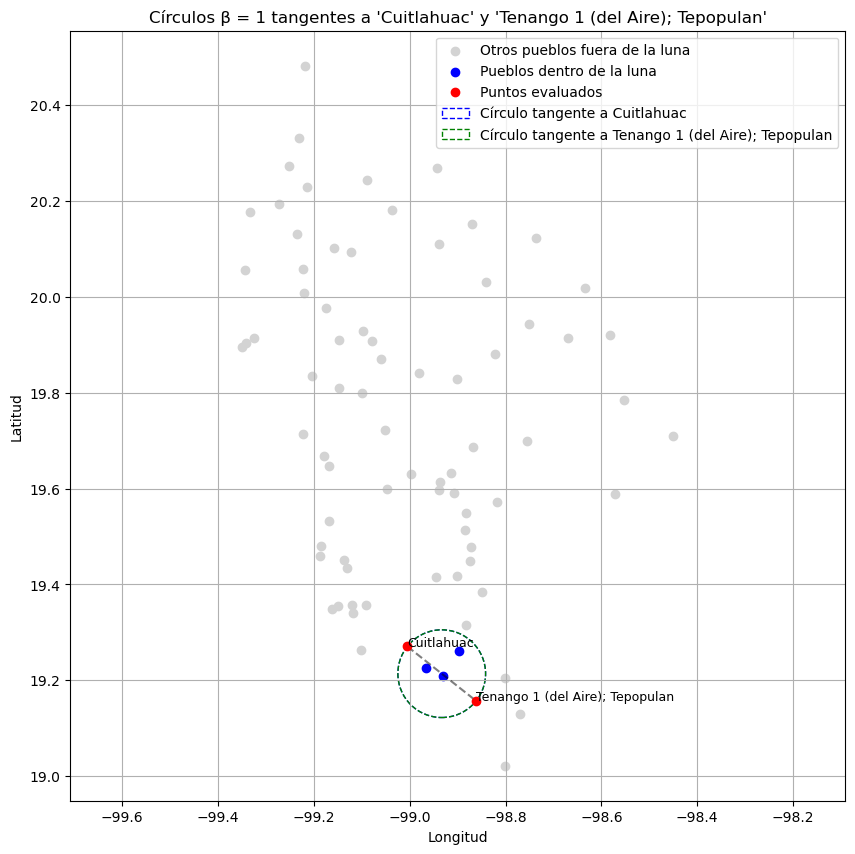

In [14]:
plot_beta_tangent_circles(coords, names, i=6, j=2, beta=1)

### Revisar todas las distancias de un solo nodo

In [15]:
def plot_beta_lunes_for_node(coords, names, i, beta=1.0):
    n = len(coords)
    p1 = coords[i]

    for j in range(n):
        if j == i:
            continue

        p2 = coords[j]
        d = np.linalg.norm(p2 - p1)
        if d == 0:
            continue

        r = (beta * d) / 2
        direction = (p2 - p1) / d
        center1 = p1 + direction * r
        center2 = p2 - direction * r

        # Clasificar puntos dentro y fuera de la luna
        in_lune = []
        out_lune = []
        for k, pk in enumerate(coords):
            if k in (i, j):
                continue
            dist1 = np.linalg.norm(pk - center1)
            dist2 = np.linalg.norm(pk - center2)
            if dist1 < r or dist2 < r:
                in_lune.append((pk, names[k]))
            else:
                out_lune.append((pk, names[k]))

        # Graficar
        fig, ax = plt.subplots(figsize=(8, 8))

        if out_lune:
            x_out, y_out = zip(*[p for p, _ in out_lune])
            ax.scatter(x_out, y_out, color='lightgray', label='Otros pueblos fuera de la luna')

        if in_lune:
            x_in, y_in = zip(*[p for p, _ in in_lune])
            ax.scatter(x_in, y_in, color='blue', label='Pueblos dentro de la luna')

        ax.scatter([p1[0], p2[0]], [p1[1], p2[1]], color='red', zorder=3)

        # Etiquetas
        ax.text(p1[0] + 0.0003, p1[1] + 0.0003, names[i], fontsize=9)
        ax.text(p2[0] + 0.0003, p2[1] + 0.0003, names[j], fontsize=9)

        # Círculos tangentes
        circle1 = Circle(center1, r, color='blue', fill=False, linestyle='--', label=f"Tangente a {names[i]}")
        circle2 = Circle(center2, r, color='green', fill=False, linestyle='--', label=f"Tangente a {names[j]}")
        ax.add_patch(circle1)
        ax.add_patch(circle2)

        # Línea entre los puntos evaluados
        ax.plot([p1[0], p2[0]], [p1[1], p2[1]], 'k--', alpha=0.5)

        ax.set_xlabel("Longitud")
        ax.set_ylabel("Latitud")
        ax.set_title(f"Luna β = {beta} entre '{names[i]}' y '{names[j]}'")
        ax.axis("equal")
        ax.grid(True)
        ax.legend()
        plt.show()


In [ ]:
# plot_beta_lunes_for_node(coords, names, i=6, beta=1)

### Beta skeletons

In [16]:
def check_lune_for_node(coords, i, beta=1.0):
    n = len(coords)
    p1 = coords[i]
    result_vector = []

    for j in range(n):
        if j == i:
            result_vector.append(0)  # No self-loop; optional choice
            continue

        p2 = coords[j]
        d = np.linalg.norm(p2 - p1)
        if d == 0:
            result_vector.append(0)
            continue

        r = (beta * d) / 2
        direction = (p2 - p1) / d
        center1 = p1 + direction * r
        center2 = p2 - direction * r

        # Check if any other point lies in the lune (intersection of both circles)
        is_clear = 1
        for k in range(n):
            if k == i or k == j:
                continue
            pk = coords[k]
            dist1 = np.linalg.norm(pk - center1)
            dist2 = np.linalg.norm(pk - center2)
            if dist1 < r and dist2 < r:
                is_clear = 0  # Found a point in the lune
                break

        result_vector.append(is_clear)

    return result_vector


In [17]:
def beta_skeleton_adjacency_matrix(coords, beta=1.0):
    n = len(coords)
    matrix = np.zeros((n, n), dtype=int)

    for i in range(n):
        row = check_lune_for_node(coords, i, beta=beta)
        matrix[i] = row

    # Make sure the matrix is symmetric (undirected graph)
    matrix = np.minimum(matrix, matrix.T)
    
    return matrix

In [26]:
import matplotlib.pyplot as plt
import networkx as nx
from adjustText import adjust_text

def plot_beta_skeleton_graph(coords, names, beta=1.0):
    # Get the adjacency matrix using the beta-skeleton rule
    adj_matrix = beta_skeleton_adjacency_matrix(coords, beta=beta)
    
    # Create graph
    G = nx.Graph()
    
    # Add nodes with positions and labels
    for i, (x, y) in enumerate(coords):
        G.add_node(i, pos=(x, y), label=names[i])
    
    # Add edges from adjacency matrix
    n = len(coords)
    for i in range(n):
        for j in range(i + 1, n):
            if adj_matrix[i, j] == 1:
                G.add_edge(i, j)

    # Plot
    pos = nx.get_node_attributes(G, 'pos')
    labels = nx.get_node_attributes(G, 'label')

    plt.figure(figsize=(12, 12))
    nx.draw(G, pos, node_color='skyblue', with_labels=False, node_size=100)

    # ✅ Create texts before calling adjust_text
    texts = []
    for i, (x, y) in pos.items():
        texts.append(plt.text(x, y, labels[i], fontsize=8))

    # ✅ Adjust text positions to avoid overlaps
    adjust_text(
        texts,
        arrowprops=dict(
            arrowstyle='->',
            color='gray',
            lw=0.5,
            shrinkA=5  # Ensures arrows don’t touch the text
        ),
        expand_points=(1.2, 1.2),
        force_text=0.5,
        force_points=0.2
    )

    plt.title(f"Gráfica β-esqueleto (β = {beta})")
    plt.grid(True)
    plt.axis("equal")
    plt.show()


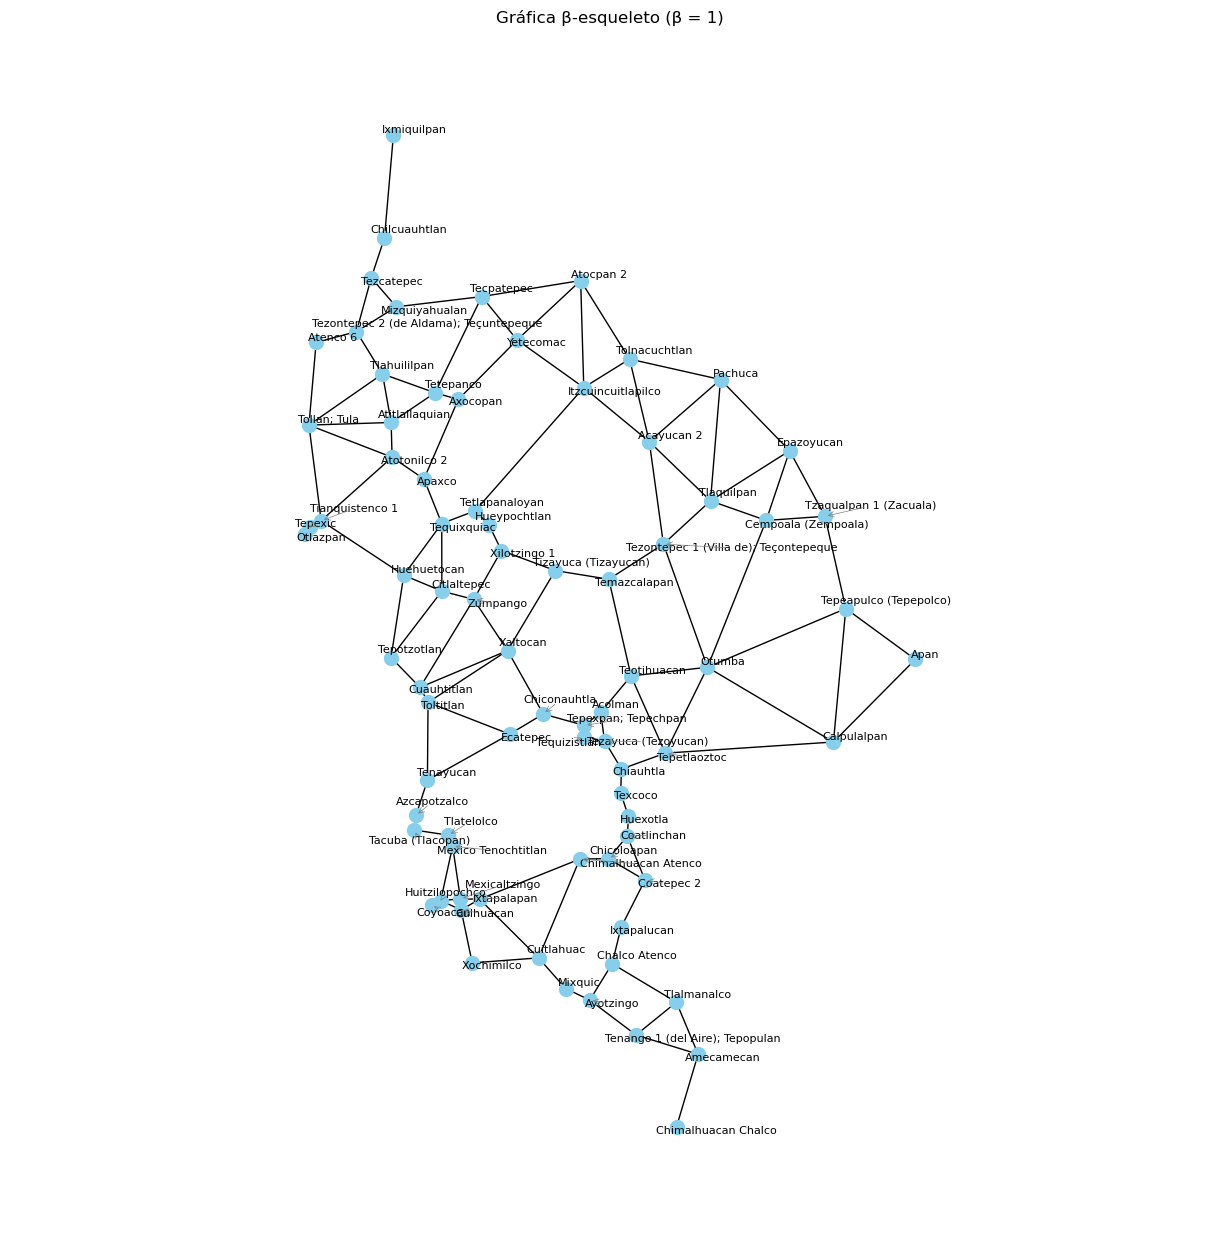

In [27]:
plot_beta_skeleton_graph(coords, names, beta=1)